In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

from optbinning import BinningProcess

# set col width
pd.set_option('display.max_colwidth', 100)

# set plot style
plt.style.use('seaborn-whitegrid')

# set palette
sns.set_palette('Set1')

(CVXPY) Dec 14 06:27:29 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Dec 14 06:27:29 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_97495/4023470249.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
def create_feature(df):
    new_features = {
    'CREDIT_DURATION': df['DAYS_CREDIT'] - df['DAYS_CREDIT_ENDDATE'],
    'ENDDATE_DIF': df['DAYS_CREDIT_ENDDATE'] - df['DAYS_ENDDATE_FACT'],
    'DEBT_PERCENTAGE': df['AMT_CREDIT_SUM'] / df['AMT_CREDIT_SUM_DEBT'],
    'DEBT_CREDIT_DIFF': df['AMT_CREDIT_SUM'] - df['AMT_CREDIT_SUM_DEBT'],
    'CREDIT_TO_ANNUITY_RATIO': df['AMT_CREDIT_SUM'] / df['AMT_ANNUITY'],
    'BUREAU_CREDIT_FACT_DIFF': df['DAYS_CREDIT'] - df['DAYS_ENDDATE_FACT'],
    'BUREAU_CREDIT_ENDDATE_DIFF': df['DAYS_CREDIT'] - df['DAYS_CREDIT_ENDDATE'],
    'BUREAU_CREDIT_DEBT_RATIO': df['AMT_CREDIT_SUM_DEBT'] / df['AMT_CREDIT_SUM'],
    'BUREAU_IS_DPD': df['CREDIT_DAY_OVERDUE'] > 0,
    'BUREAU_IS_DPD_OVER60': df['CREDIT_DAY_OVERDUE'] > 60,
    'BUREAU_IS_DPD_OVER120': df['CREDIT_DAY_OVERDUE'] > 120,
    'UTILIZATION_RATIO': df['AMT_CREDIT_SUM_DEBT'] / df['AMT_CREDIT_SUM_LIMIT'],
    # DAYS_CREDIT_mean
    'DAYS_CREDIT_mean': df.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean(),
    # last_active_DAYS_CREDIT
    'last_active_DAYS_CREDIT': df.groupby('SK_ID_CURR')['DAYS_CREDIT'].last(),
    # BUREAU_AVG_LOAN_12M
    'BUREAU_AVG_LOAN_12M': df.groupby('SK_ID_CURR')['DAYS_CREDIT'].rolling(window=12).mean(),
    # BUREAU_PCT_HIGH_DEBT_RATIO
    'BUREAU_PCT_HIGH_DEBT_RATIO': (df['AMT_CREDIT_SUM_DEBT'] > 0.5 * df['AMT_CREDIT_SUM']).mean(),
    }

    df = pd.concat([df, pd.DataFrame(new_features)], axis=1)
    return df

# Load data

In [3]:
# Load 
bureau = pd.read_csv('../raw-data/dseb63_bureau.csv')
bureau_balance = pd.read_csv('../raw-data/dseb63_bureau_balance.csv')

In [4]:
# Load target
target = pd.read_csv('../processed-data/target.csv')
target

SK_ID_CURR  TARGET
0                0       0
1                1       1
2                2       0
3                3       0
4                4       0
...            ...     ...
246004      307505       0
246005      307506       0
246006      307507       0
246007      307509       0
246008      307510       0

[246009 rows x 2 columns]

# Bureau Balance

In [5]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [6]:
bureau_balance.describe()

SK_ID_BUREAU  MONTHS_BALANCE
count  2.729992e+07    2.729992e+07
mean   6.036297e+06   -3.074169e+01
std    4.923489e+05    2.386451e+01
min    5.001709e+06   -9.600000e+01
25%    5.730933e+06   -4.600000e+01
50%    6.070821e+06   -2.500000e+01
75%    6.431951e+06   -1.100000e+01
max    6.842888e+06    0.000000e+00

In [7]:
bureau_balance.describe(include='O')

STATUS
count   27299925
unique         8
top            C
freq    13646993

### Descriptive

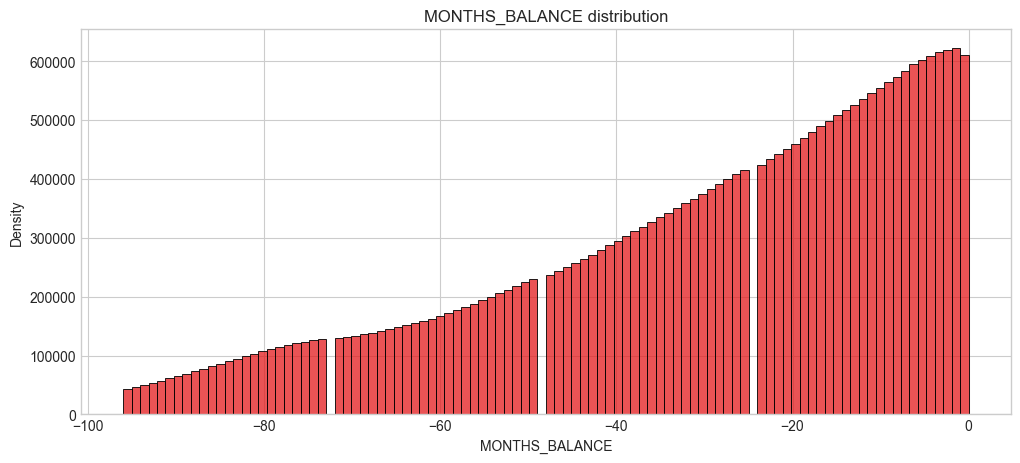

In [8]:
# Plot MONTHS_BALANCE
plt.figure(figsize=(12, 5))
sns.histplot(bureau_balance['MONTHS_BALANCE'], bins=100)
plt.title('MONTHS_BALANCE distribution')
plt.xlabel('MONTHS_BALANCE')
plt.ylabel('Density')
plt.show()

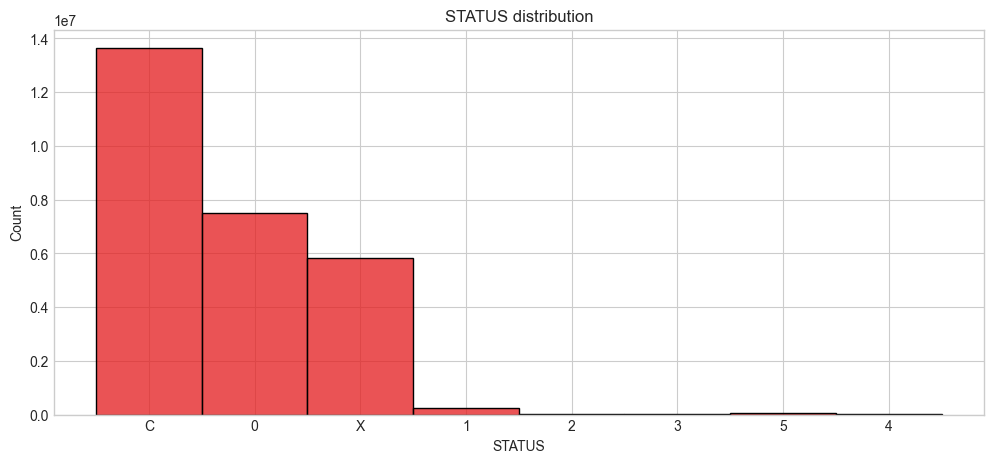

In [9]:
# Plot STATUS
plt.figure(figsize=(12, 5))
sns.histplot(bureau_balance['STATUS'])
plt.title('STATUS distribution')
plt.xlabel('STATUS')
plt.ylabel('Count')
plt.show()

### Group by SK_ID_BUREAU

In [10]:
# Get dummy variables nan as a category
bureau_balance = pd.get_dummies(bureau_balance, dummy_na=True)

In [11]:
# Group by SK_ID_BUREAU
bureau_balance = bureau_balance.groupby('SK_ID_BUREAU').agg(['min', 'max', 'mean', 'sum'])
bureau_balance.columns = ['_'.join(col).upper() for col in bureau_balance.columns]
bureau_balance

MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_MEAN  \
SK_ID_BUREAU                                                                
5001709                      -96                   0                -48.0   
5001710                      -82                   0                -41.0   
5001711                       -3                   0                 -1.5   
5001712                      -18                   0                 -9.0   
5001713                      -21                   0                -10.5   
...                          ...                 ...                  ...   
6842884                      -47                   0                -23.5   
6842885                      -23                   0                -11.5   
6842886                      -32                   0                -16.0   
6842887                      -36                   0                -18.0   
6842888                      -61                   0                -30.5   

              MONTHS_BALANCE_SUM  STATUS_0_MIN  STATUS_0_MAX  STATUS_0_MEAN  \
SK_ID_BUREAU                                                                  
5001709                    -4656         False         False       0.000000   
5001710                    -3403         False          True       0.060241   
5001711                       -6         False          True       0.750000   
5001712                     -171         False          True       0.526316   
5001713                     -231         False         False       0.000000   
...                          ...           ...           ...            ...   
6842884                    -1128         False          True       0.187500   
6842885                     -276         False          True       0.500000   
6842886                     -528         False          True       0.242424   
6842887                     -666         False          True       0.162162   
6842888                    -1891         False          True       0.145161   

              STATUS_0_SUM  STATUS_1_MIN  STATUS_1_MAX  ...  STATUS_C_MEAN  \
SK_ID_BUREAU                                            ...                  
5001709                  0         False         False  ...       0.886598   
5001710                  5         False         False  ...       0.578313   
5001711                  3         False         False  ...       0.000000   
5001712                 10         False         False  ...       0.473684   
5001713                  0         False         False  ...       0.000000   
...                    ...           ...           ...  ...            ...   
6842884                  9         False         False  ...       0.416667   
6842885                 12         False         False  ...       0.000000   
6842886                  8         False         False  ...       0.757576   
6842887                  6         False         False  ...       0.837838   
6842888                  9         False          True  ...       0.838710   

              STATUS_C_SUM  STATUS_X_MIN  STATUS_X_MAX  STATUS_X_MEAN  \
SK_ID_BUREAU                                                            
5001709                 86         False          True       0.113402   
5001710                 48         False          True       0.361446   
5001711                  0         False          True       0.250000   
5001712                  9         False         False       0.000000   
5001713                  0          True          True       1.000000   
...                    ...           ...           ...            ...   
6842884                 20         False          True       0.395833   
6842885                  0         False         False       0.000000   
6842886                 25         False         False       0.000000   
6842887                 31         False         False       0.000000   
6842888                 52         False         False       0.000000   

              STATU

In [12]:
# Astype float
bureau_balance = bureau_balance.astype(float)

# Drop cols with 1 unique value
cols_to_drop = [col for col in bureau_balance.columns if bureau_balance[col].nunique() <= 1]
bureau_balance.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop

['STATUS_2_MIN',
 'STATUS_3_MIN',
 'STATUS_4_MIN',
 'STATUS_NAN_MIN',
 'STATUS_NAN_MAX',
 'STATUS_NAN_MEAN',
 'STATUS_NAN_SUM']

### Outliers

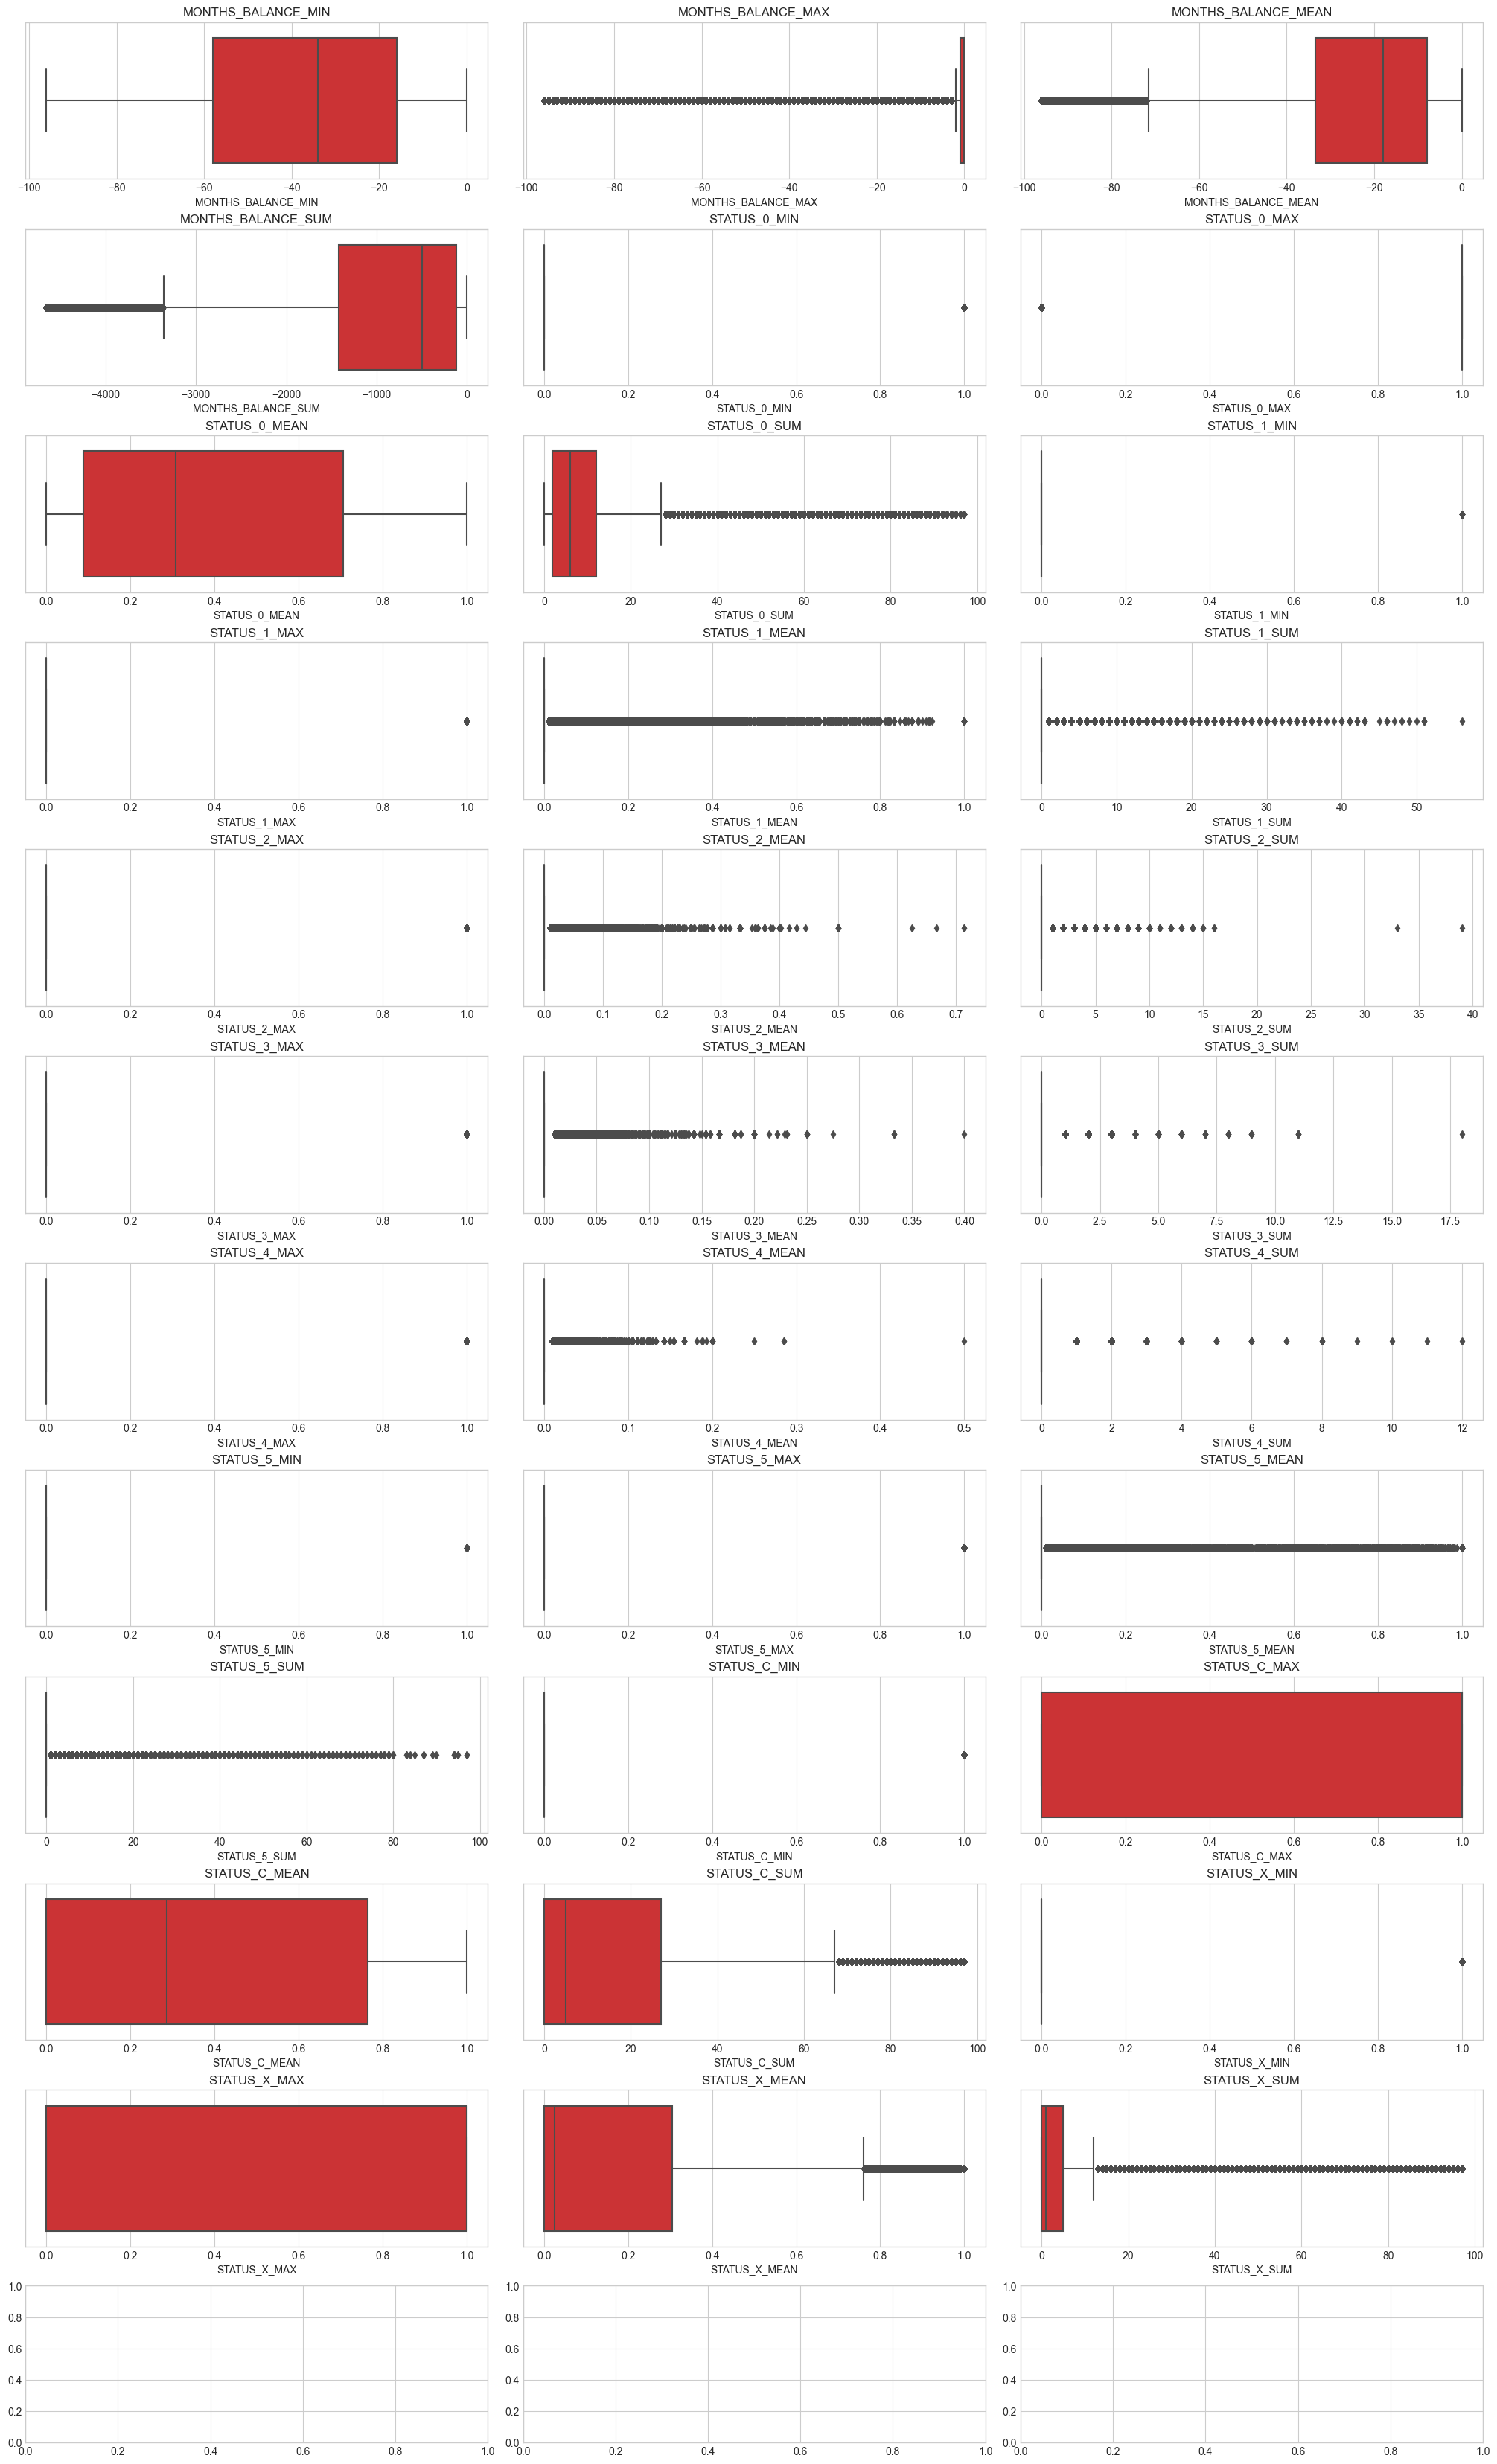

In [13]:
# Boxplot
cols_to_plot = bureau_balance.columns.to_list()
ncol, nrow = 3, len(cols_to_plot) // 3 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.boxplot(x=bureau_balance[column], ax=ax)
    ax.set_title(column)

plt.show()

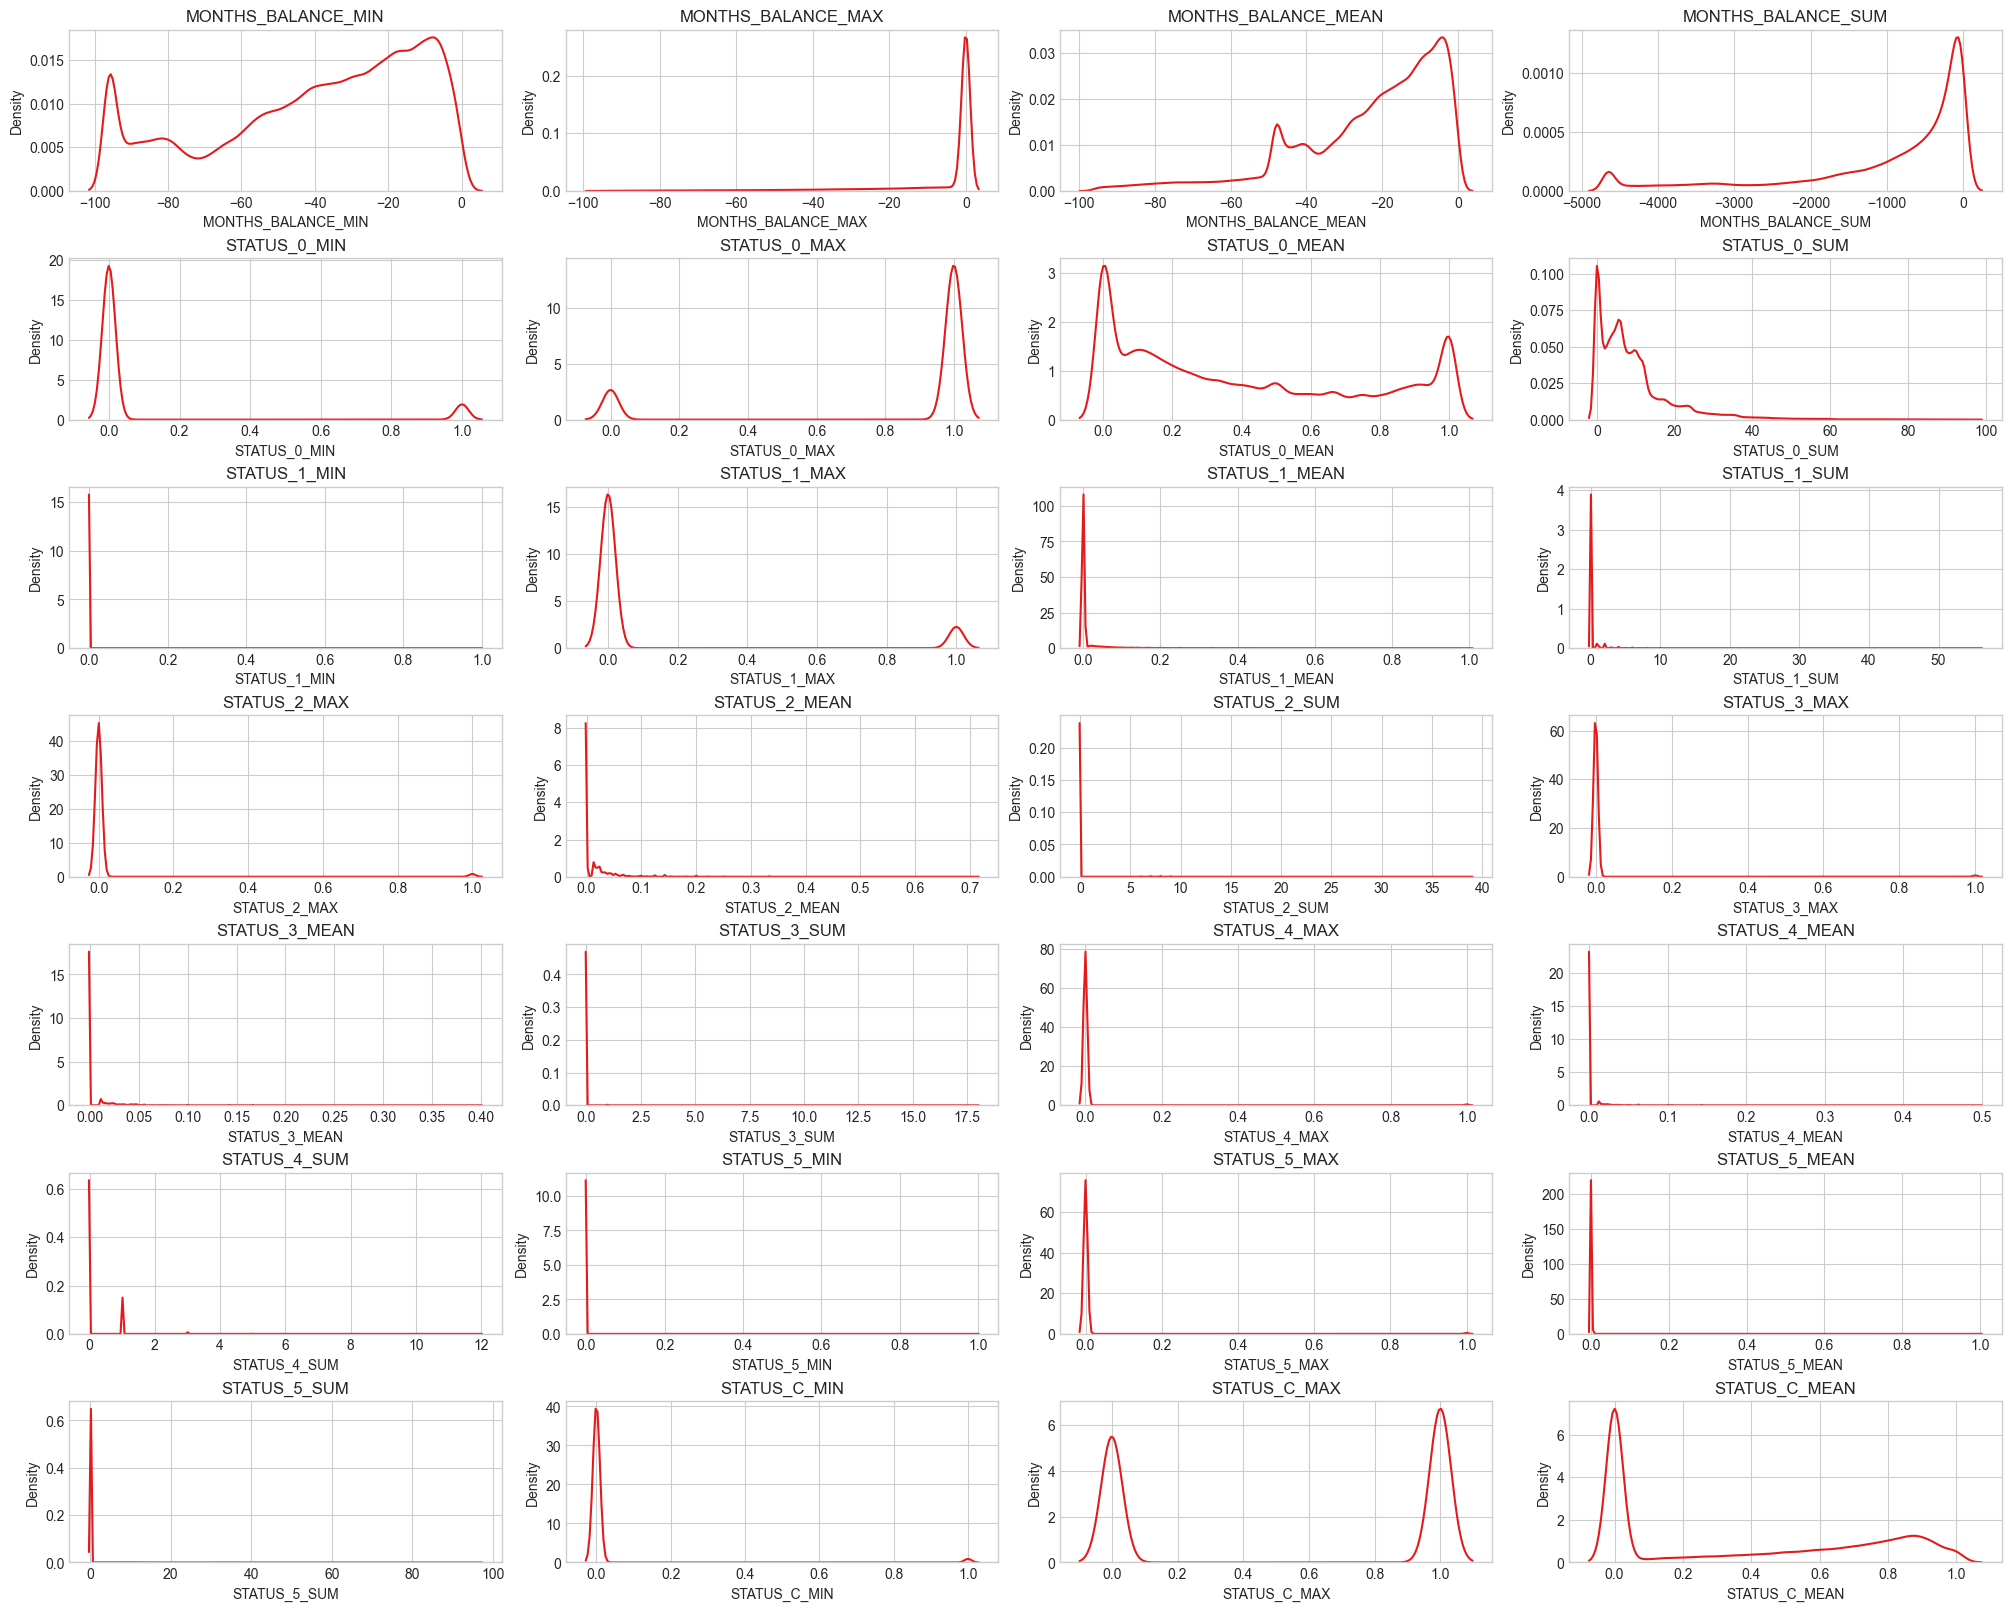

In [14]:
# Plot distribution of all columns
ncol, nrow = 4, len(bureau_balance.columns) // 5 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)//2), constrained_layout=True)

for ax, column in zip(axes.flatten(), bureau_balance.columns):
    sns.kdeplot(bureau_balance[column], ax=ax)
    ax.set_title(column)

plt.show()

### Missing Values

In [15]:
print('Number of null values:', bureau_balance.isnull().sum().sum())

Number of null values: 0


# Bureau

In [16]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465325 entries, 0 to 1465324
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_BUREAU            1465325 non-null  int64  
 1   CREDIT_ACTIVE           1465325 non-null  object 
 2   CREDIT_CURRENCY         1465325 non-null  object 
 3   DAYS_CREDIT             1465325 non-null  int64  
 4   CREDIT_DAY_OVERDUE      1465325 non-null  int64  
 5   DAYS_CREDIT_ENDDATE     1376227 non-null  float64
 6   DAYS_ENDDATE_FACT       920652 non-null   float64
 7   AMT_CREDIT_MAX_OVERDUE  516780 non-null   float64
 8   CNT_CREDIT_PROLONG      1465325 non-null  int64  
 9   AMT_CREDIT_SUM          1465322 non-null  float64
 10  AMT_CREDIT_SUM_DEBT     1242231 non-null  float64
 11  AMT_CREDIT_SUM_LIMIT    975655 non-null   float64
 12  AMT_CREDIT_SUM_OVERDUE  1465325 non-null  float64
 13  CREDIT_TYPE             1465325 non-null  object 
 14  DA

In [17]:
# Create new features
bureau = create_feature(bureau)
bureau.head()

SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0     5714462.0        Closed      currency 1       -497.0   
1     5714463.0        Active      currency 1       -208.0   
2     5714464.0        Active      currency 1       -203.0   
3     5714465.0        Active      currency 1       -203.0   
4     5714466.0        Active      currency 1       -629.0   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                 0.0               -153.0             -153.0   
1                 0.0               1075.0                NaN   
2                 0.0                528.0                NaN   
3                 0.0                  NaN                NaN   
4                 0.0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  ...  \
0                     NaN                 0.0         91323.0  ...   
1                     NaN                 0.0        225000.0  ...   
2                     NaN                 0.0        464323.5  ...   
3                     NaN                 0.0         90000.0  ...   
4                 77674.5                 0.0       2700000.0  ...   

   BUREAU_CREDIT_ENDDATE_DIFF  BUREAU_CREDIT_DEBT_RATIO  BUREAU_IS_DPD  \
0                      -344.0                   0.00000          False   
1                     -1283.0                   0.76152          False   
2                      -731.0                       NaN          False   
3                         NaN                       NaN          False   
4                     -1826.0                       NaN          False   

  BUREAU_IS_DPD_OVER60  BUREAU_IS_DPD_OVER120  UTILIZATION_RATIO  \
0                False                  False                NaN   
1                False                  False                NaN   
2                False                  False                NaN   
3                False                  False                NaN   
4                False                  False                NaN   

   DAYS_CREDIT_mean  last_active_DAYS_CREDIT  BUREAU_AVG_LOAN_12M  \
0        -63.000000                    -63.0                  NaN   
1      -2348.000000                  -2348.0                  NaN   
2       -810.333333                  -2901.0                  NaN   
3      -1131.428571                   -342.0                  NaN   
4       -773.333333                   -313.0                  NaN   

   BUREAU_PCT_HIGH_DEBT_RATIO  
0                     0.19105  
1                     0.19105  
2                     0.19105  
3                     0.19105  
4                     0.19105  

[5 rows x 33 columns]

In [18]:
num_cols = bureau.select_dtypes(include=np.number).columns.to_list()
num_cols.remove('SK_ID_CURR')
num_cols.remove('SK_ID_BUREAU')

cat_cols = bureau.select_dtypes(include='O').columns.to_list()

## Descriptive

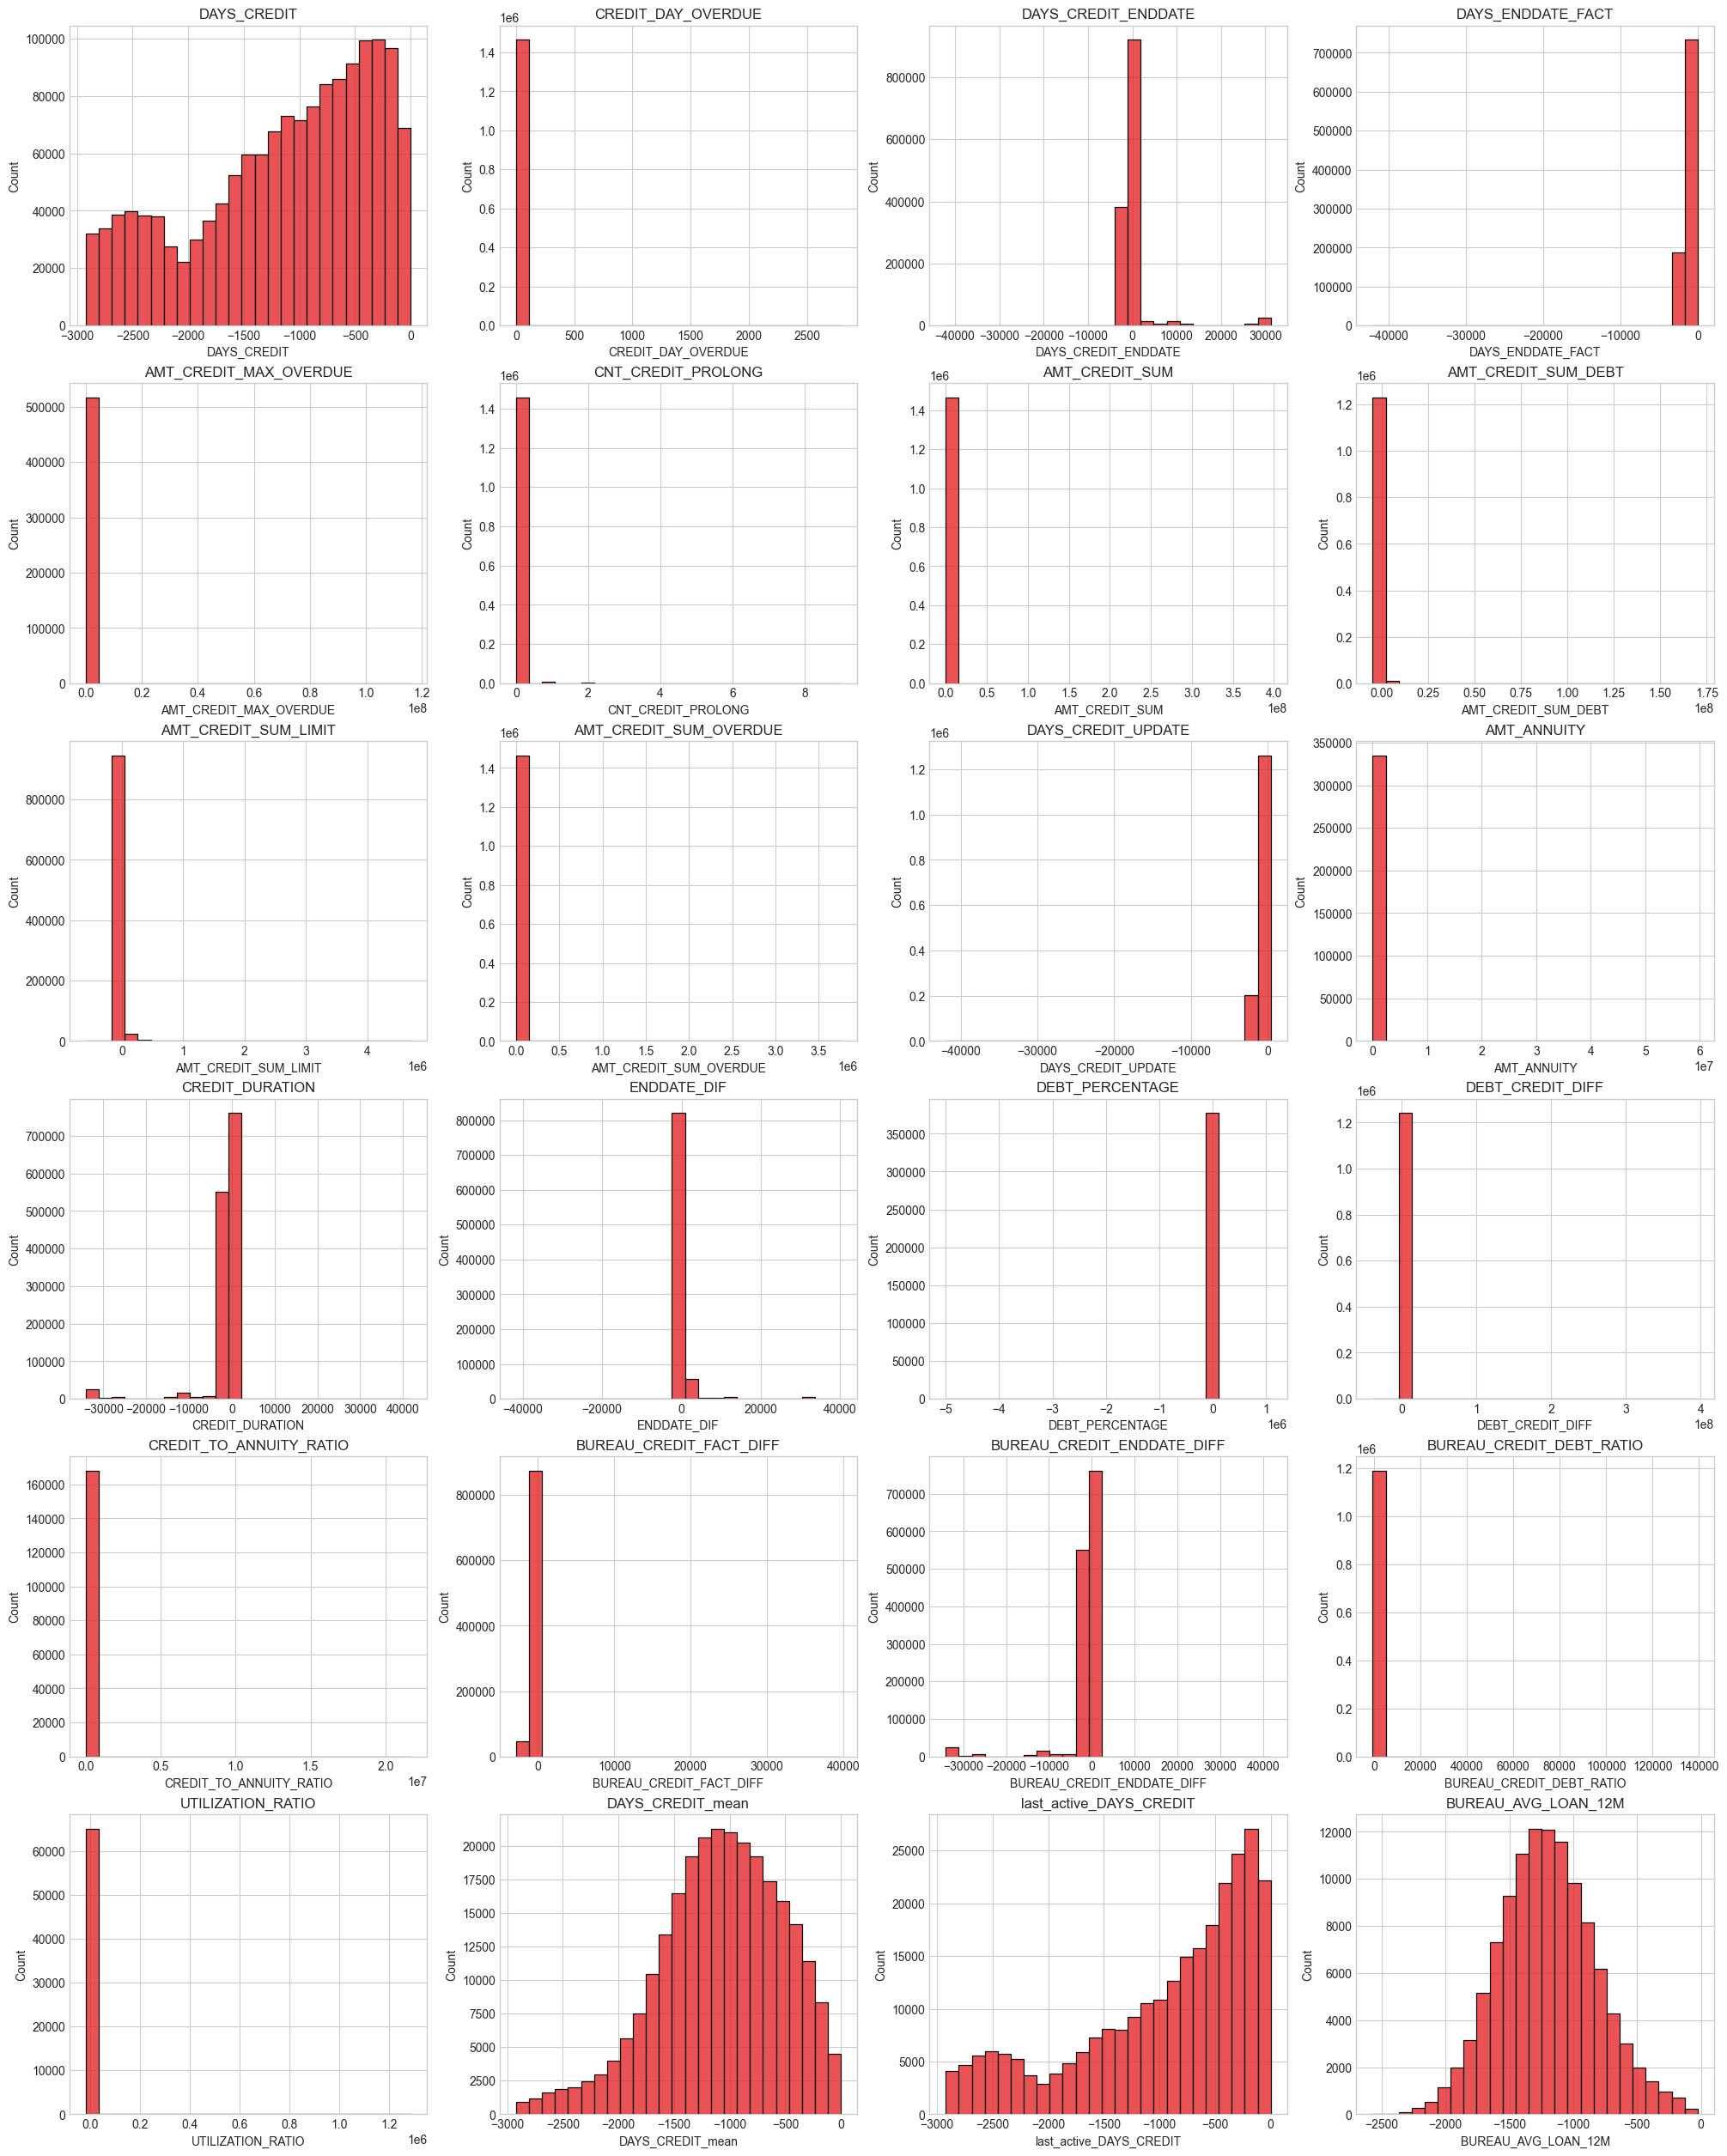

In [19]:
# Plot histogram of numerical columns
ncol, nrow = 4, len(num_cols) // 5 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.histplot(bureau[column], ax=ax, bins=25)
    ax.set_title(column)

plt.show()

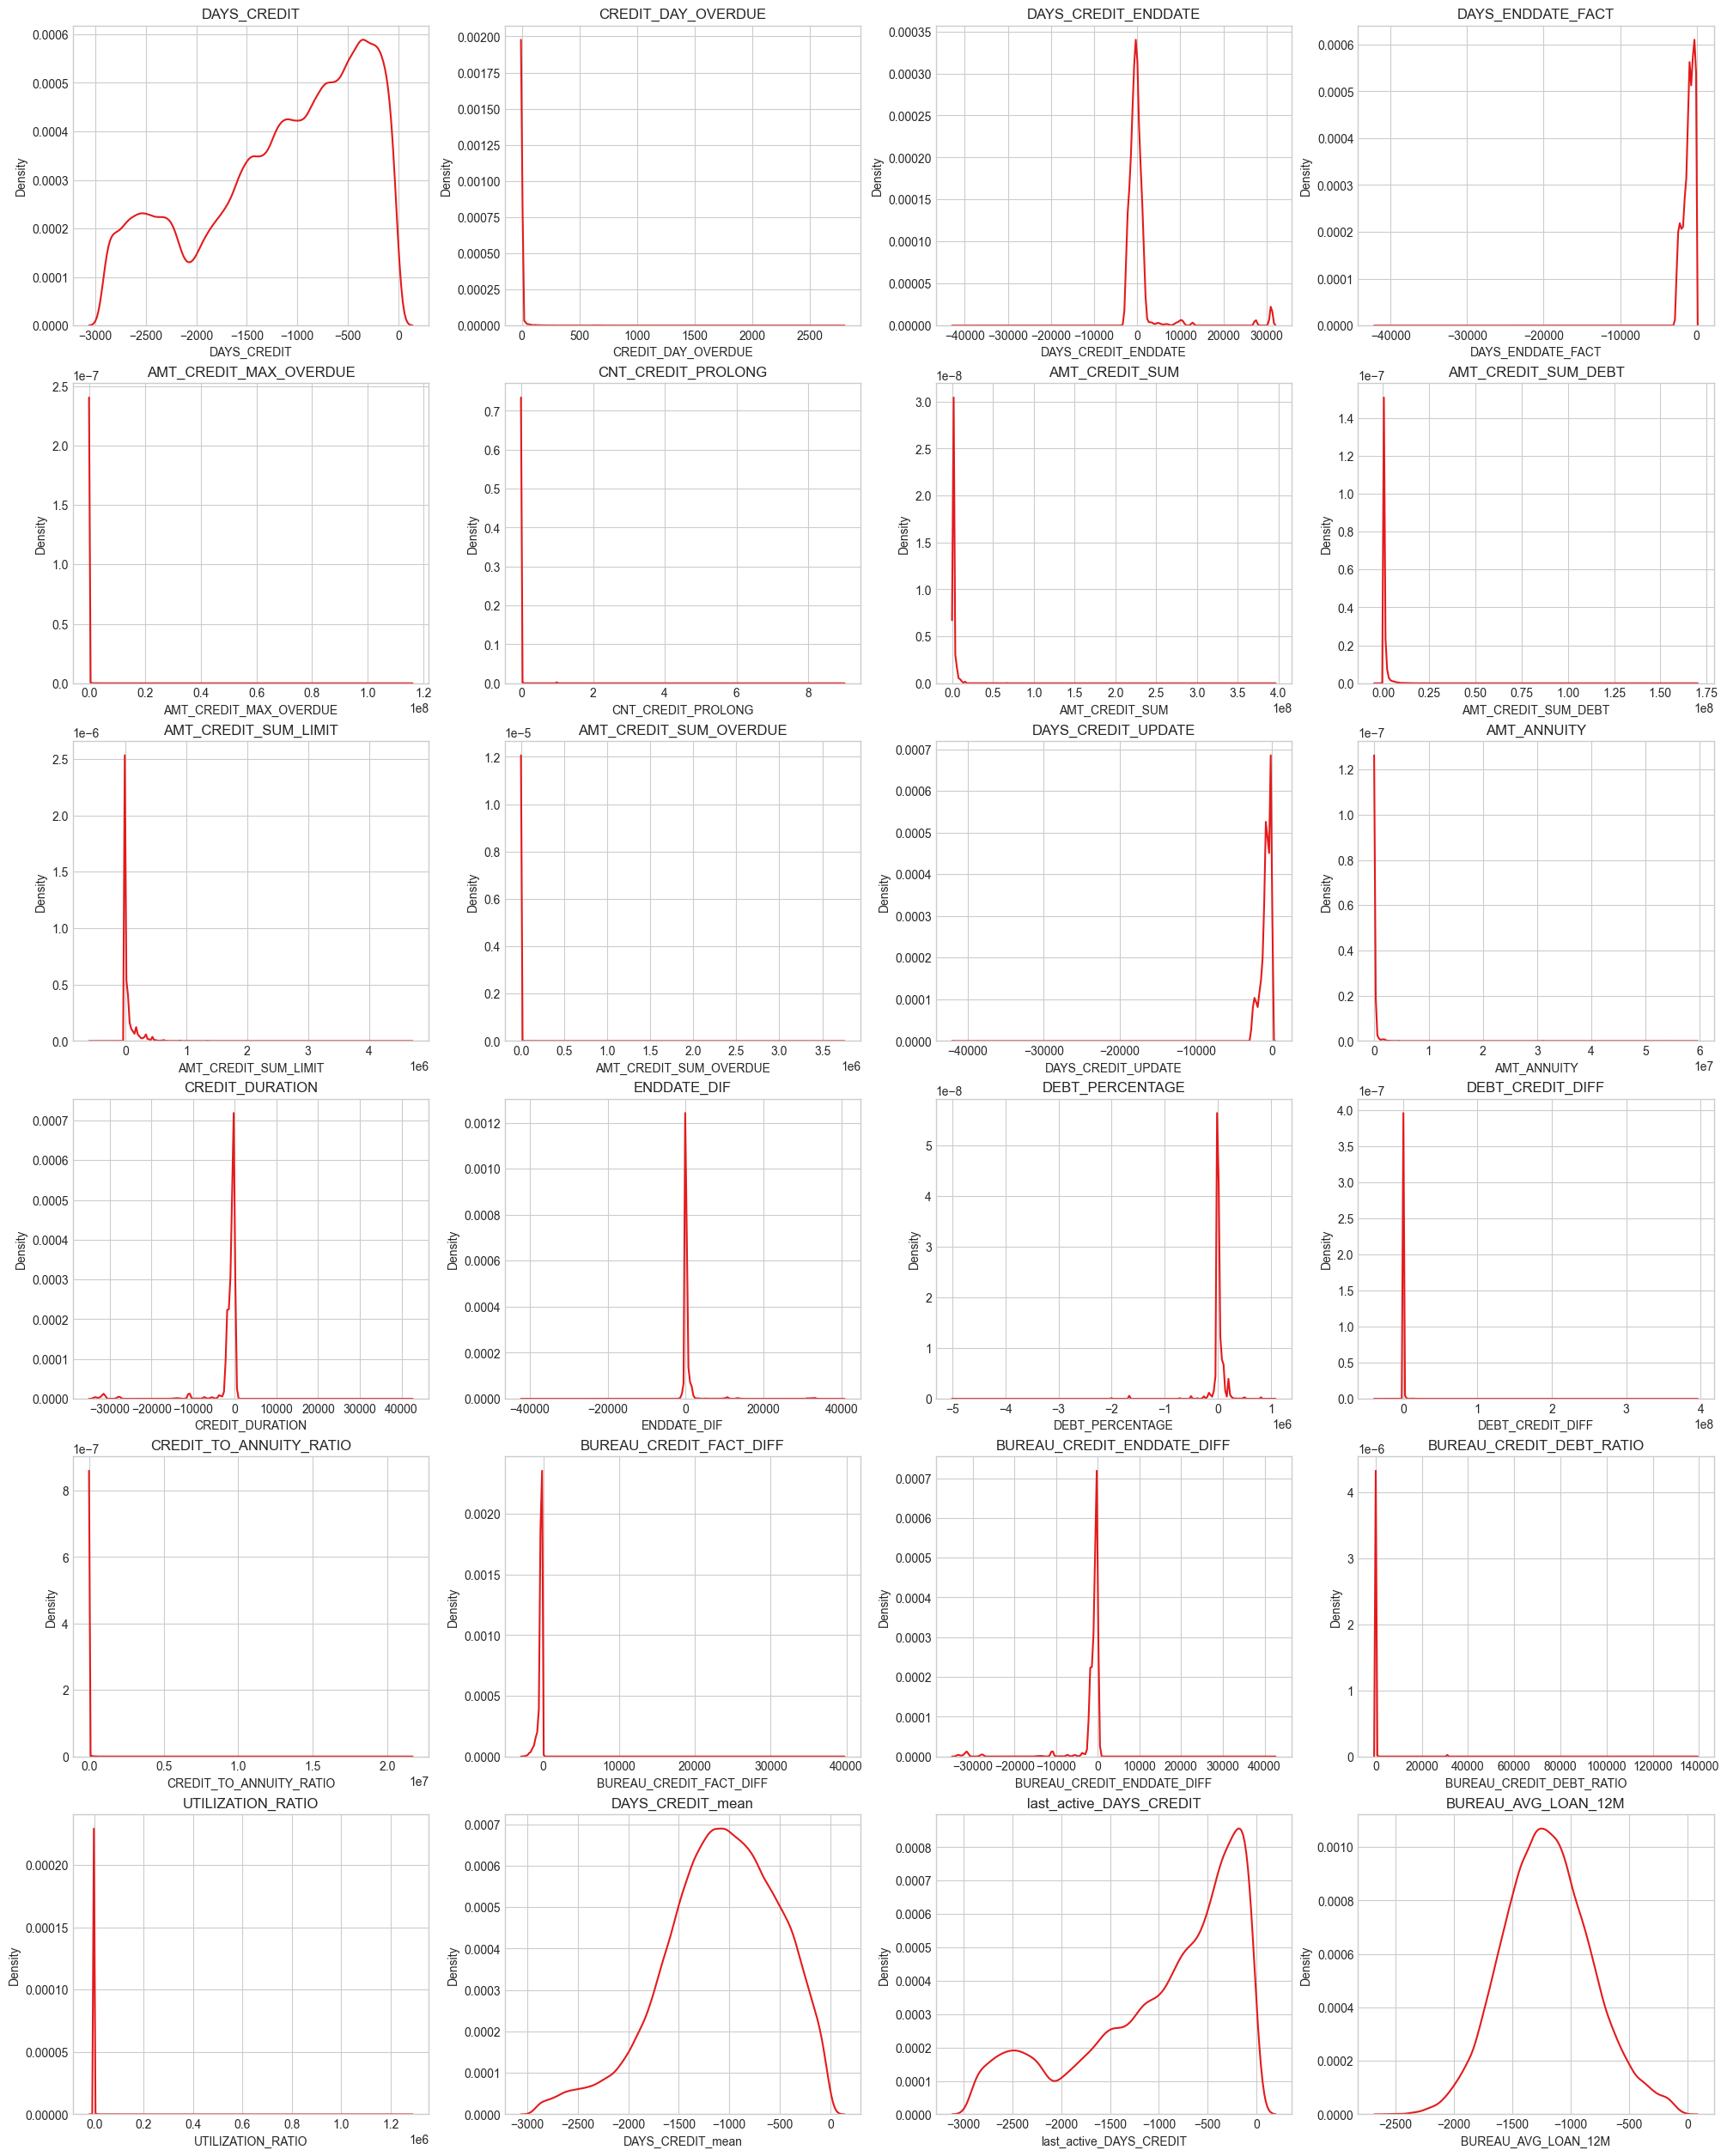

In [20]:
# Plot distribution of numerical columns
ncol, nrow = 4, len(num_cols) // 5 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(num_cols)), constrained_layout=True)

for ax, column in zip(axes.flatten(), num_cols):
    sns.kdeplot(bureau[column], ax=ax)
    ax.set_title(column)

plt.show()

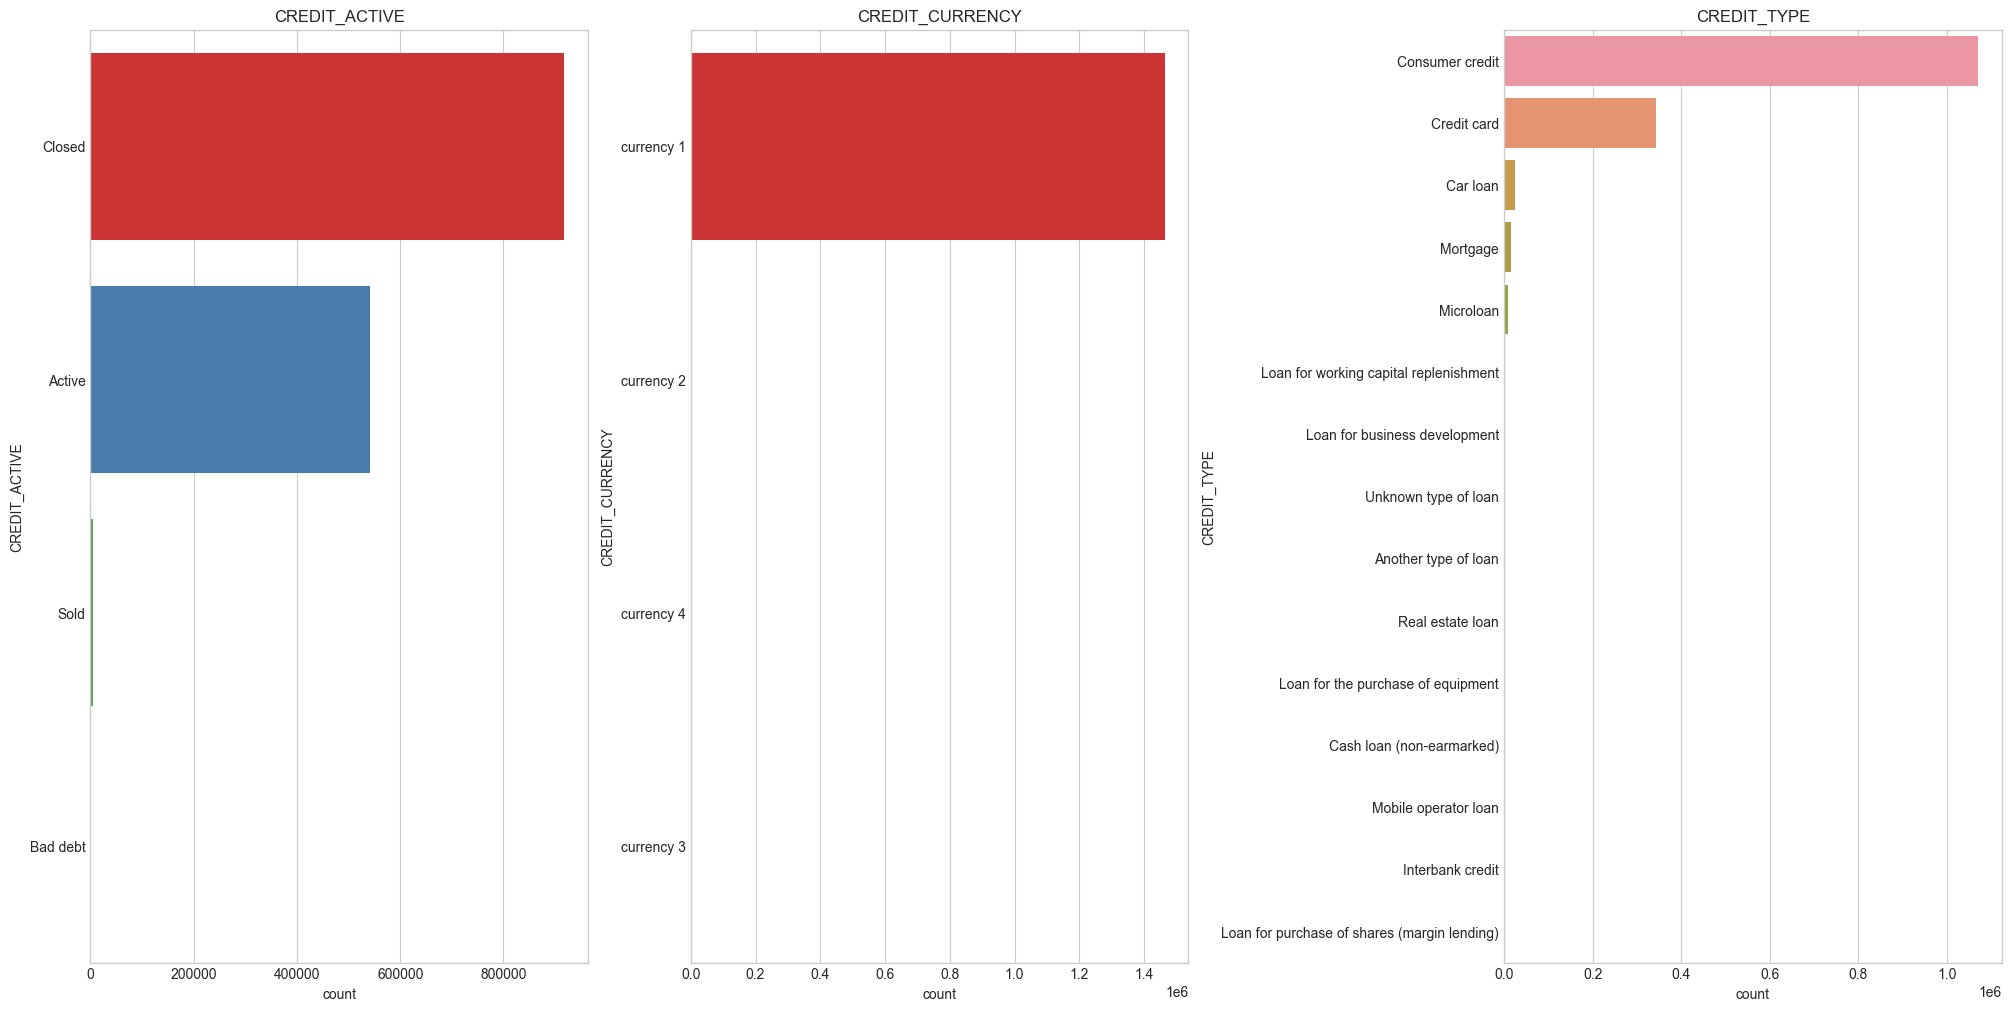

In [21]:
# Plot distribution of categorical columns
ncol, nrow = 3, 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 10), constrained_layout=True)

for ax, column in zip(axes.flatten(), cat_cols):
    sns.countplot(y=bureau[column], ax=ax)
    ax.set_title(column)

plt.show()

## Missing Values

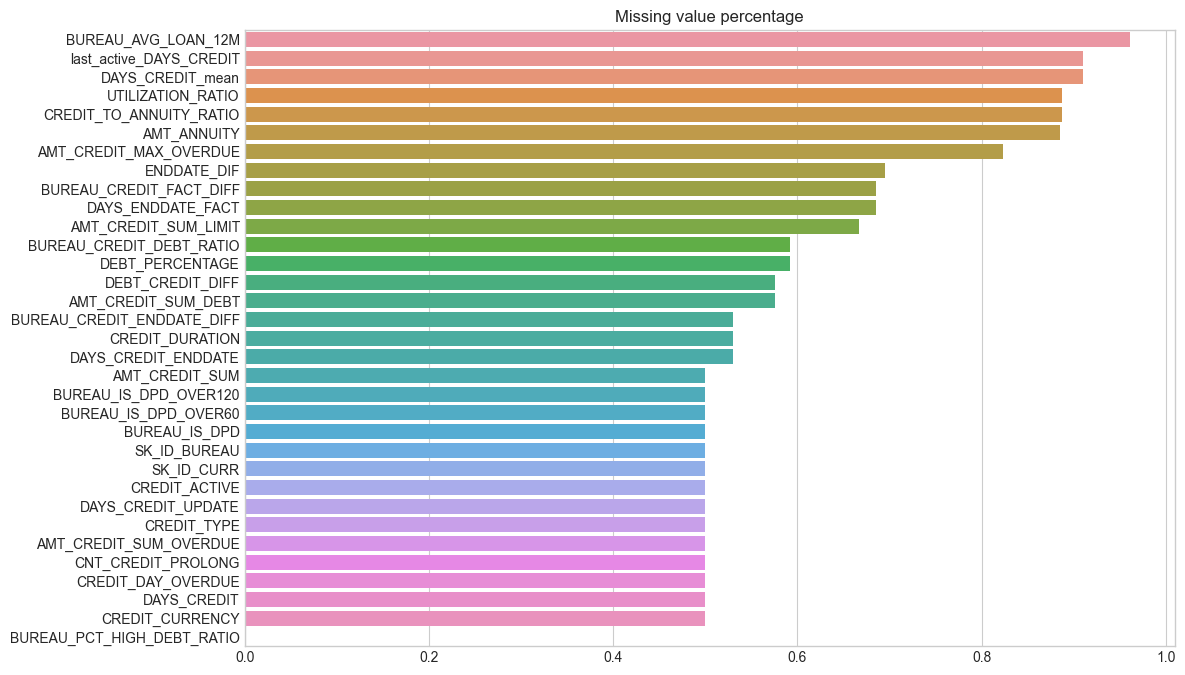

In [22]:
# Horizontal barplot of missing value percentage
plt.figure(figsize=(12, 8))
sns.barplot(x=bureau.isnull().mean().sort_values(ascending=False), y=bureau.isnull().mean().sort_values(ascending=False).index)
plt.title('Missing value percentage')
plt.show()

## Correlation

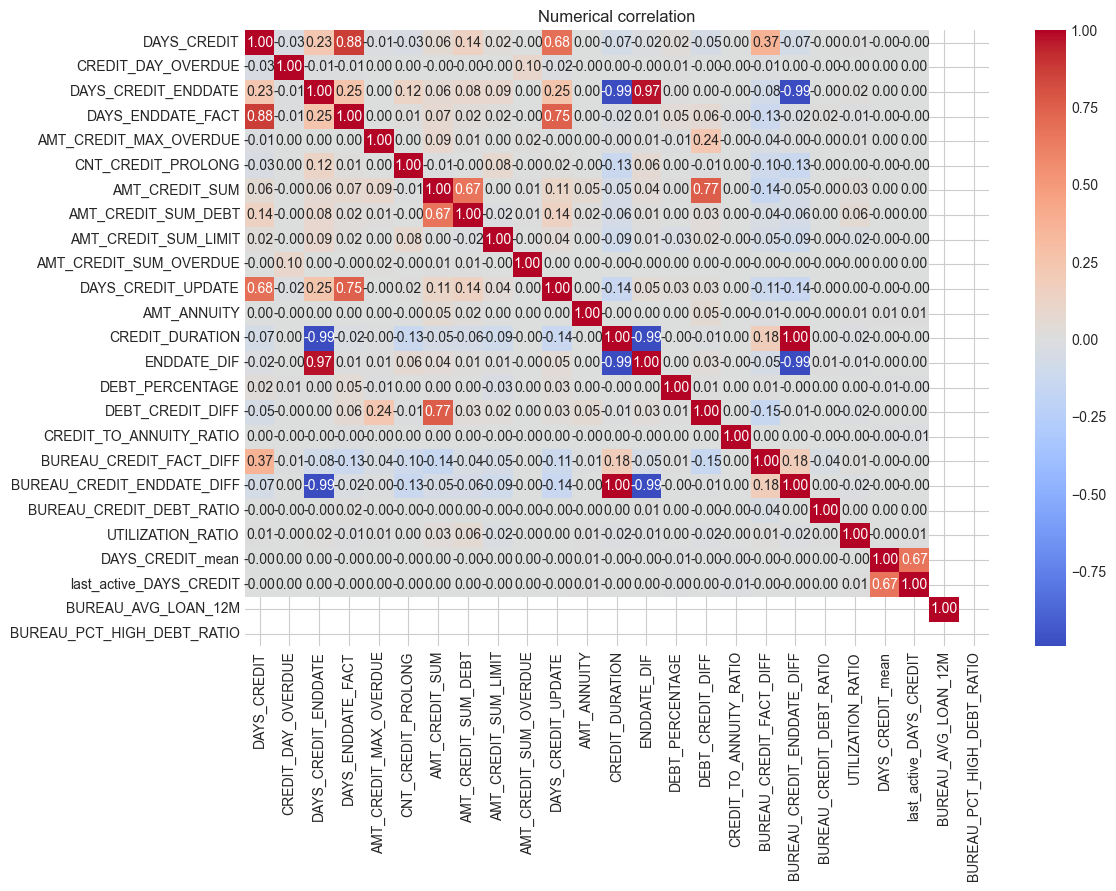

In [23]:
# Plot numerical correlation
plt.figure(figsize=(12, 8))
sns.heatmap(bureau[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numerical correlation')
plt.show()

# Group by SK_ID_CURR

In [24]:
bureau.head()

SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0     5714462.0        Closed      currency 1       -497.0   
1     5714463.0        Active      currency 1       -208.0   
2     5714464.0        Active      currency 1       -203.0   
3     5714465.0        Active      currency 1       -203.0   
4     5714466.0        Active      currency 1       -629.0   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                 0.0               -153.0             -153.0   
1                 0.0               1075.0                NaN   
2                 0.0                528.0                NaN   
3                 0.0                  NaN                NaN   
4                 0.0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  ...  \
0                     NaN                 0.0         91323.0  ...   
1                     NaN                 0.0        225000.0  ...   
2                     NaN                 0.0        464323.5  ...   
3                     NaN                 0.0         90000.0  ...   
4                 77674.5                 0.0       2700000.0  ...   

   BUREAU_CREDIT_ENDDATE_DIFF  BUREAU_CREDIT_DEBT_RATIO  BUREAU_IS_DPD  \
0                      -344.0                   0.00000          False   
1                     -1283.0                   0.76152          False   
2                      -731.0                       NaN          False   
3                         NaN                       NaN          False   
4                     -1826.0                       NaN          False   

  BUREAU_IS_DPD_OVER60  BUREAU_IS_DPD_OVER120  UTILIZATION_RATIO  \
0                False                  False                NaN   
1                False                  False                NaN   
2                False                  False                NaN   
3                False                  False                NaN   
4                False                  False                NaN   

   DAYS_CREDIT_mean  last_active_DAYS_CREDIT  BUREAU_AVG_LOAN_12M  \
0        -63.000000                    -63.0                  NaN   
1      -2348.000000                  -2348.0                  NaN   
2       -810.333333                  -2901.0                  NaN   
3      -1131.428571                   -342.0                  NaN   
4       -773.333333                   -313.0                  NaN   

   BUREAU_PCT_HIGH_DEBT_RATIO  
0                     0.19105  
1                     0.19105  
2                     0.19105  
3                     0.19105  
4                     0.19105  

[5 rows x 33 columns]

In [25]:
# Get dummy variables
bureau = pd.get_dummies(bureau, dummy_na=True)
bureau = bureau.astype(float)

# Drop cols with 1 unique value
cols_to_drop = [col for col in bureau.columns if bureau[col].nunique() <= 1]
bureau.drop(cols_to_drop, axis=1, inplace=True)
cols_to_drop

['BUREAU_PCT_HIGH_DEBT_RATIO']

### Merge with Bureau Balance

In [26]:
# Merge bureau and bureau_balance
bureau = bureau.merge(bureau_balance, how='left', on='SK_ID_BUREAU')

# Drop SK_ID_BUREAU
bureau.drop('SK_ID_BUREAU', axis=1, inplace=True)
bureau.head()

DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0       -497.0                 0.0               -153.0             -153.0   
1       -208.0                 0.0               1075.0                NaN   
2       -203.0                 0.0                528.0                NaN   
3       -203.0                 0.0                  NaN                NaN   
4       -629.0                 0.0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                 0.0         91323.0   
1                     NaN                 0.0        225000.0   
2                     NaN                 0.0        464323.5   
3                     NaN                 0.0         90000.0   
4                 77674.5                 0.0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  ...  \
0                  0.0                   NaN                     0.0  ...   
1             171342.0                   NaN                     0.0  ...   
2                  NaN                   NaN                     0.0  ...   
3                  NaN                   NaN                     0.0  ...   
4                  NaN                   NaN                     0.0  ...   

   STATUS_5_MEAN  STATUS_5_SUM  STATUS_C_MIN  STATUS_C_MAX  STATUS_C_MEAN  \
0            NaN           NaN           NaN           NaN            NaN   
1            NaN           NaN           NaN           NaN            NaN   
2            NaN           NaN           NaN           NaN            NaN   
3            NaN           NaN           NaN           NaN            NaN   
4            NaN           NaN           NaN           NaN            NaN   

   STATUS_C_SUM  STATUS_X_MIN  STATUS_X_MAX  STATUS_X_MEAN  STATUS_X_SUM  
0           NaN           NaN           NaN            NaN           NaN  
1           NaN           NaN           NaN            NaN           NaN  
2           NaN           NaN           NaN            NaN           NaN  
3           NaN           NaN           NaN            NaN           NaN  
4           NaN           NaN           NaN            NaN           NaN  

[5 rows x 93 columns]

In [27]:
# Group by SK_ID_CURR
bureau = bureau.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum'])
bureau.columns = ['_'.join(col).upper() for col in bureau.columns]
bureau

DAYS_CREDIT_MIN  DAYS_CREDIT_MAX  DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                       
0.0                   -63.0            -63.0        -63.000000   
1.0                 -2348.0          -2348.0      -2348.000000   
2.0                 -2901.0            -30.0       -810.333333   
3.0                 -2865.0           -116.0      -1131.428571   
4.0                 -1056.0           -313.0       -773.333333   
...                     ...              ...               ...   
307504.0            -1701.0           -728.0      -1149.750000   
307505.0             -772.0           -151.0       -461.500000   
307506.0            -1559.0          -1222.0      -1390.500000   
307508.0            -1957.0            -95.0       -765.428571   
307509.0            -2864.0           -291.0      -1577.500000   

            DAYS_CREDIT_SUM  CREDIT_DAY_OVERDUE_MIN  CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                                    
0.0                   -63.0                     0.0                     0.0   
1.0                 -2348.0                     0.0                     0.0   
2.0                 -4862.0                     0.0                     0.0   
3.0                 -7920.0                     0.0                     0.0   
4.0                 -4640.0                     0.0                     0.0   
...                     ...                     ...                     ...   
307504.0            -4599.0                     0.0                     0.0   
307505.0             -923.0                     0.0                     0.0   
307506.0            -5562.0                     0.0                     0.0   
307508.0            -5358.0                     0.0                     0.0   
307509.0            -3155.0                     0.0                     0.0   

            CREDIT_DAY_OVERDUE_MEAN  CREDIT_DAY_OVERDUE_SUM  \
SK_ID_CURR                                                    
0.0                             0.0                     0.0   
1.0                             0.0                     0.0   
2.0                             0.0                     0.0   
3.0                             0.0                     0.0   
4.0                             0.0                     0.0   
...                             ...                     ...   
307504.0                        0.0                     0.0   
307505.0                        0.0                     0.0   
307506.0                        0.0                     0.0   
307508.0                        0.0                     0.0   
307509.0                        0.0                     0.0   

            DAYS_CREDIT_ENDDATE_MIN  DAYS_CREDIT_ENDDATE_MAX  ...  \
SK_ID_CURR                                                    ...   
0.0                           237.0                    237.0  ...   
1.0                         -2044.0                  -2044.0  ...   
2.0                         -2597.0                    274.0  ...   
3.0                         -2683.0                    502.0  ...   
4.0                          -509.0                   1148.0  ...   
...                             ...                      ...  ...   
307504.0                    -1344.0                    734.0  ...   
307505.0                     1675.0                  10188.0  ...   
307506.0                    -1375.0                   -856.0  ...   
307508.0                     -691.0                   3061.0  ...   
307509.0                    -2315.0                   1027.0  ...   

            STATUS_X_MAX_MEAN  STATUS_X_MAX_SUM  STATUS_X_MEAN_MIN  \
SK_ID_CURR                                                           
0.0                       NaN               0.0                NaN   
1.0                  0.000000               0.0           0.000000   
2.0                       NaN               0.0                NaN   
3.0                       NaN               0.0          

In [28]:
# Drop cols with 1 unique value
cols_to_drop = [col for col in bureau.columns if bureau[col].nunique() <= 1]
bureau.drop(cols_to_drop, axis=1, inplace=True)
print(cols_to_drop)
bureau.head()

['BUREAU_AVG_LOAN_12M_MIN', 'BUREAU_AVG_LOAN_12M_MAX', 'BUREAU_AVG_LOAN_12M_MEAN', 'BUREAU_AVG_LOAN_12M_SUM', 'CREDIT_ACTIVE_BAD DEBT_MIN', 'CREDIT_ACTIVE_NAN_MIN', 'CREDIT_ACTIVE_NAN_MAX', 'CREDIT_ACTIVE_NAN_MEAN', 'CREDIT_ACTIVE_NAN_SUM', 'CREDIT_CURRENCY_CURRENCY 4_MIN', 'CREDIT_CURRENCY_NAN_MIN', 'CREDIT_CURRENCY_NAN_MAX', 'CREDIT_CURRENCY_NAN_MEAN', 'CREDIT_CURRENCY_NAN_SUM', 'CREDIT_TYPE_CASH LOAN (NON-EARMARKED)_MIN', 'CREDIT_TYPE_INTERBANK CREDIT_MIN', 'CREDIT_TYPE_LOAN FOR PURCHASE OF SHARES (MARGIN LENDING)_MIN', 'CREDIT_TYPE_MOBILE OPERATOR LOAN_MIN', 'CREDIT_TYPE_NAN_MIN', 'CREDIT_TYPE_NAN_MAX', 'CREDIT_TYPE_NAN_MEAN', 'CREDIT_TYPE_NAN_SUM', 'BUREAU_IS_DPD_NAN_MIN', 'BUREAU_IS_DPD_NAN_MAX', 'BUREAU_IS_DPD_NAN_MEAN', 'BUREAU_IS_DPD_NAN_SUM', 'BUREAU_IS_DPD_OVER60_NAN_MIN', 'BUREAU_IS_DPD_OVER60_NAN_MAX', 'BUREAU_IS_DPD_OVER60_NAN_MEAN', 'BUREAU_IS_DPD_OVER60_NAN_SUM', 'BUREAU_IS_DPD_OVER120_NAN_MIN', 'BUREAU_IS_DPD_OVER120_NAN_MAX', 'BUREAU_IS_DPD_OVER120_NAN_MEAN', 'BUREAU_

DAYS_CREDIT_MIN  DAYS_CREDIT_MAX  DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                       
0.0                   -63.0            -63.0        -63.000000   
1.0                 -2348.0          -2348.0      -2348.000000   
2.0                 -2901.0            -30.0       -810.333333   
3.0                 -2865.0           -116.0      -1131.428571   
4.0                 -1056.0           -313.0       -773.333333   

            DAYS_CREDIT_SUM  CREDIT_DAY_OVERDUE_MIN  CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                                    
0.0                   -63.0                     0.0                     0.0   
1.0                 -2348.0                     0.0                     0.0   
2.0                 -4862.0                     0.0                     0.0   
3.0                 -7920.0                     0.0                     0.0   
4.0                 -4640.0                     0.0                     0.0   

            CREDIT_DAY_OVERDUE_MEAN  CREDIT_DAY_OVERDUE_SUM  \
SK_ID_CURR                                                    
0.0                             0.0                     0.0   
1.0                             0.0                     0.0   
2.0                             0.0                     0.0   
3.0                             0.0                     0.0   
4.0                             0.0                     0.0   

            DAYS_CREDIT_ENDDATE_MIN  DAYS_CREDIT_ENDDATE_MAX  ...  \
SK_ID_CURR                                                    ...   
0.0                           237.0                    237.0  ...   
1.0                         -2044.0                  -2044.0  ...   
2.0                         -2597.0                    274.0  ...   
3.0                         -2683.0                    502.0  ...   
4.0                          -509.0                   1148.0  ...   

            STATUS_X_MAX_MEAN  STATUS_X_MAX_SUM  STATUS_X_MEAN_MIN  \
SK_ID_CURR                                                           
0.0                       NaN               0.0                NaN   
1.0                       0.0               0.0                0.0   
2.0                       NaN               0.0                NaN   
3.0                       NaN               0.0                NaN   
4.0                       NaN               0.0                NaN   

            STATUS_X_MEAN_MAX  STATUS_X_MEAN_MEAN  STATUS_X_MEAN_SUM  \
SK_ID_CURR                                                             
0.0                       NaN                 NaN                0.0   
1.0                       0.0                 0.0                0.0   
2.0                       NaN                 NaN                0.0   
3.0                       NaN                 NaN                0.0   
4.0                       NaN                 NaN                0.0   

            STATUS_X_SUM_MIN  STATUS_X_SUM_MAX  STATUS_X_SUM_MEAN  \
SK_ID_CURR                                                          
0.0                      NaN               NaN                NaN   
1.0                      0.0               0.0                0.0   
2.0                      NaN               NaN                NaN   
3.0                      NaN               NaN                NaN   
4.0                      NaN               NaN                NaN   

            STATUS_X_SUM_SUM  
SK_ID_CURR                    
0.0                      0.0  
1.0                      0.0  
2.0                      0.0  
3.0                      0.0  
4.0                      0.0  

[5 rows x 333 columns]

## Descriptive

In [29]:
num_cols = bureau.select_dtypes(include=np.number).columns.to_list()
len(num_cols)

333

In [30]:
# Merge with target
bureau = bureau.merge(target, how='left', on='SK_ID_CURR')
bureau.head()

SK_ID_CURR  DAYS_CREDIT_MIN  DAYS_CREDIT_MAX  DAYS_CREDIT_MEAN  \
0         0.0            -63.0            -63.0        -63.000000   
1         1.0          -2348.0          -2348.0      -2348.000000   
2         2.0          -2901.0            -30.0       -810.333333   
3         3.0          -2865.0           -116.0      -1131.428571   
4         4.0          -1056.0           -313.0       -773.333333   

   DAYS_CREDIT_SUM  CREDIT_DAY_OVERDUE_MIN  CREDIT_DAY_OVERDUE_MAX  \
0            -63.0                     0.0                     0.0   
1          -2348.0                     0.0                     0.0   
2          -4862.0                     0.0                     0.0   
3          -7920.0                     0.0                     0.0   
4          -4640.0                     0.0                     0.0   

   CREDIT_DAY_OVERDUE_MEAN  CREDIT_DAY_OVERDUE_SUM  DAYS_CREDIT_ENDDATE_MIN  \
0                      0.0                     0.0                    237.0   
1                      0.0                     0.0                  -2044.0   
2                      0.0                     0.0                  -2597.0   
3                      0.0                     0.0                  -2683.0   
4                      0.0                     0.0                   -509.0   

   ...  STATUS_X_MAX_SUM  STATUS_X_MEAN_MIN  STATUS_X_MEAN_MAX  \
0  ...               0.0                NaN                NaN   
1  ...               0.0                0.0                0.0   
2  ...               0.0                NaN                NaN   
3  ...               0.0                NaN                NaN   
4  ...               0.0                NaN                NaN   

   STATUS_X_MEAN_MEAN  STATUS_X_MEAN_SUM  STATUS_X_SUM_MIN  STATUS_X_SUM_MAX  \
0                 NaN                0.0               NaN               NaN   
1                 0.0                0.0               0.0               0.0   
2                 NaN                0.0               NaN               NaN   
3                 NaN                0.0               NaN               NaN   
4                 NaN                0.0               NaN               NaN   

   STATUS_X_SUM_MEAN  STATUS_X_SUM_SUM  TARGET  
0                NaN               0.0     0.0  
1                0.0               0.0     1.0  
2                NaN               0.0     0.0  
3                NaN               0.0     0.0  
4                NaN               0.0     0.0  

[5 rows x 335 columns]

In [36]:
# Split train and test
train_df = bureau[bureau['TARGET'].notnull()]
test_df = bureau[bureau['TARGET'].isnull()]

# Astype target
train_df['TARGET'] = train_df['TARGET'].astype(int)

/var/folders/mp/v9hjfv017hbfgx9mc09nw2y80000gn/T/ipykernel_97495/730026254.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['TARGET'] = train_df['TARGET'].astype(int)


In [37]:
# Check duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

Plotting 150 columns


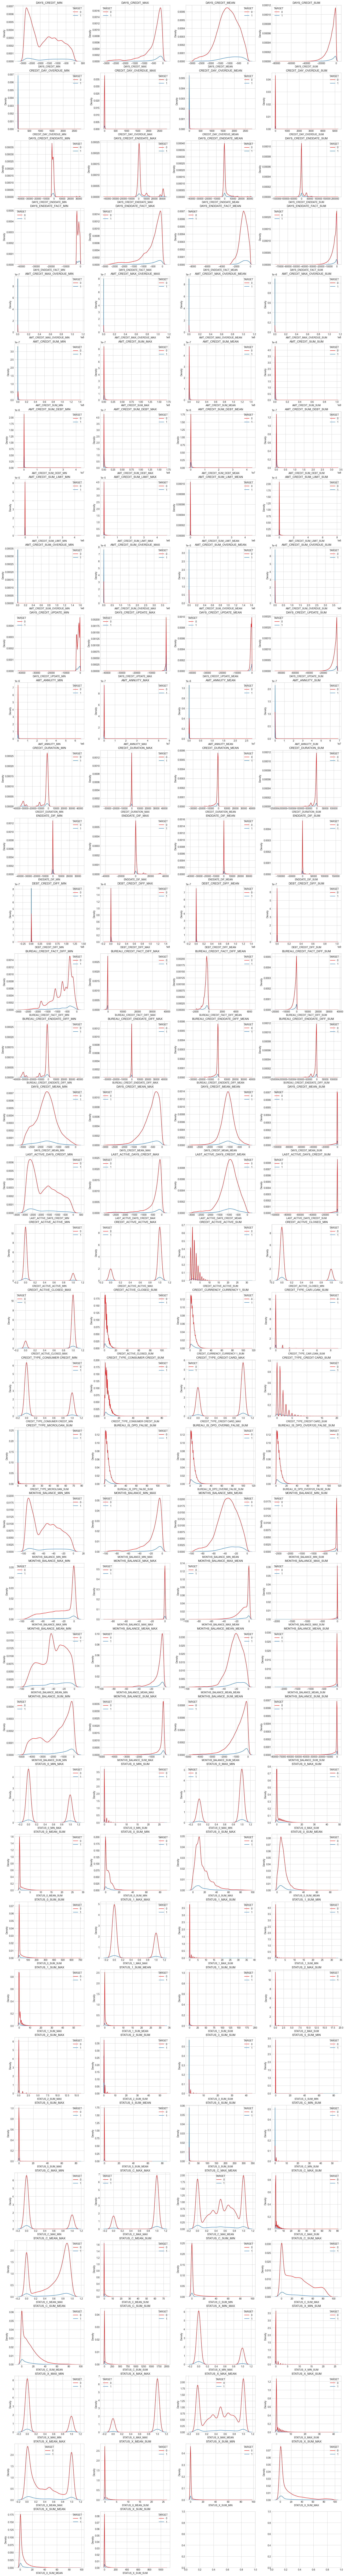

In [40]:
# Plot kdeplot hue target
cols_to_plot = [col for col in num_cols if bureau[col].var() > 0.1]
print('Plotting {} columns'.format(len(cols_to_plot)))
ncol, nrow = 4, len(cols_to_plot) // 4 + 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, len(cols_to_plot)), constrained_layout=True)

for ax, column in zip(axes.flatten(), cols_to_plot):
    sns.kdeplot(x=train_df[column], hue=train_df['TARGET'], ax=ax)
    ax.set_title(column)

plt.show()